# error analysis 
series_idごとのoof scoreをチェック
errorがどういう波形に対して発生しているかを確認する

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append("/kaggle/src/dss_utils")

from dss_metrics import score

# Config

In [3]:
output_dir = os.path.join("/kaggle", "working", "_oof")
exp_name = "exp006_addlayer"
# exp_name = "debug"

In [4]:
for i in range(5):
    print("fold", i)
    oof_df = pd.concat(
        [pd.read_parquet(os.path.join(output_dir, exp_name, f"oof_df_fold{i}.parquet"))]
        ,axis=0
    )

fold 0


fold 1
fold 2
fold 3
fold 4


In [5]:
train_event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")

In [6]:
sub_df = pd.read_csv(os.path.join(output_dir, exp_name, "sub_df.csv"))

In [7]:
score_df = pd.read_csv(os.path.join(output_dir, exp_name, "score_df.csv"))
display(score_df)

,series_id,score,detected_event_num
0,038441c925bb,0.631418,264
1,03d92c9f6f8a,0.000000,0
2,0402a003dae9,0.503222,213
3,04f547b8017d,0.000000,0
4,05e1944c3818,0.000000,0
...,...,...,...
264,fa149c3c4bde,0.000000,0
265,fb223ed2278c,0.000000,0
266,fbf33b1a2c10,0.000000,0
267,fcca183903b7,0.000000,0


In [8]:
low_score_df = pd.read_csv(os.path.join(output_dir, exp_name, "low_score_keys.csv"))

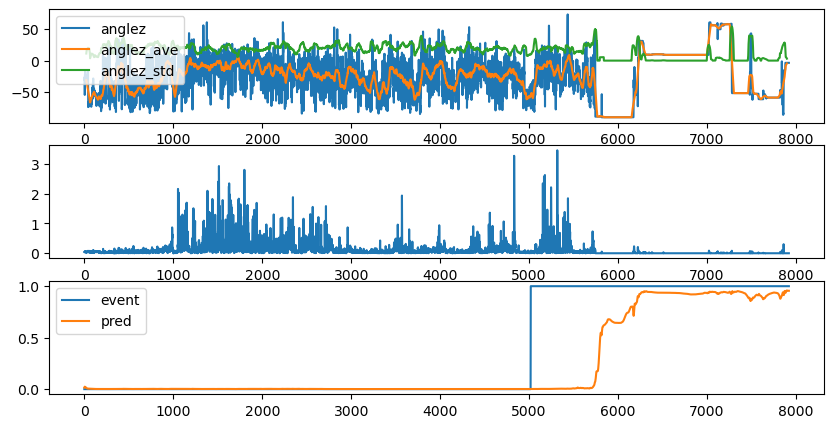

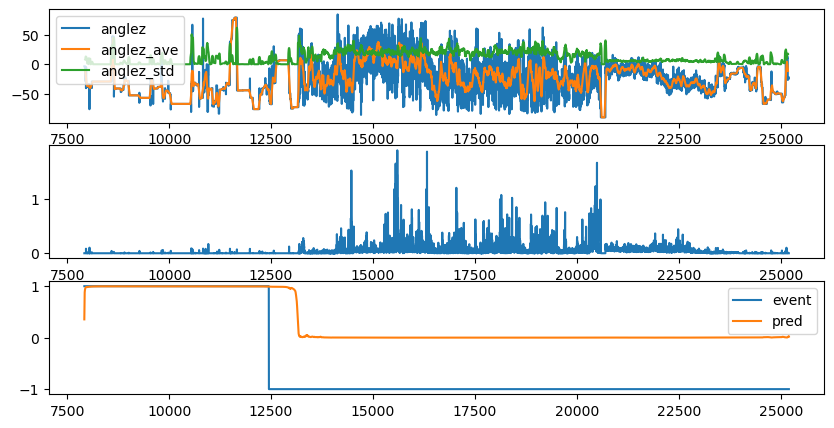

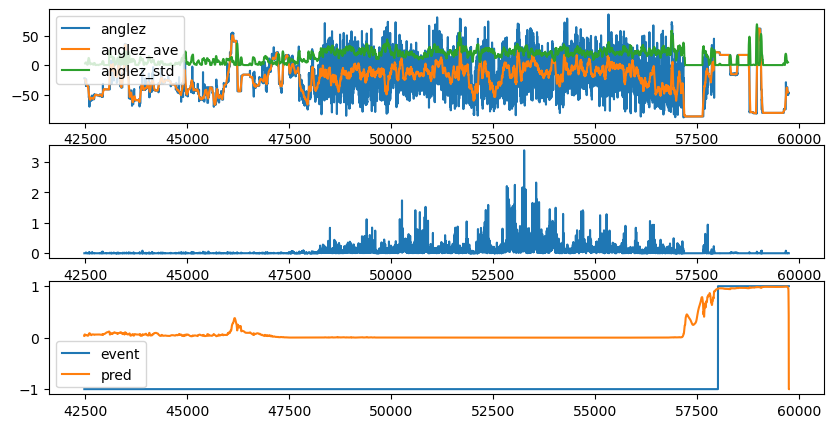

In [18]:
key_tmp = None
show_idx = 10
count = 0
show_num = 2
for idx, key in enumerate(low_score_df["series_date_key"]):
    if count > show_num:
        break
    df = oof_df[oof_df["series_date_key"]==key]
    series_id = df["series_id"].unique()[0]
    min_step = df["step"].min()
    max_step = df["step"].max()
    event = train_event_df[train_event_df["series_id"]==series_id]
    event = event[(event["step"]>=min_step) & (event["step"]<=max_step)]
    if len(event) == 0:
        continue

    count += 1
    
    sub = sub_df[sub_df["series_id"]==series_id]
    sub = sub[(sub["step"]>=min_step) & (sub["step"]<=max_step)]
    sub = sub.sort_values("score", ascending=True)[:5]
    score = score_df[score_df["series_id"]==series_id]["score"].values[0]

    n= 15
    df[f"anglez_ave_{n}"] = df["anglez"].rolling(n, center=True).mean()
    df[f"anglez_std_{n}"] = df["anglez"].rolling(n, center=True).std()
    n= 30
    df[f"anglez_ave_{n}"] = df["anglez"].rolling(n, center=True).mean()
    df[f"anglez_std_{n}"] = df["anglez"].rolling(n, center=True).std()
    n= 45
    df[f"anglez_ave_{n}"] = df["anglez"].rolling(n, center=True).mean()
    df[f"anglez_std_{n}"] = df["anglez"].rolling(n, center=True).std()

    n = 45
    plt.figure(figsize=(10, 5))
    plt.subplot(3, 1, 1)
    plt.plot(df["step"], df["anglez"], label="anglez")
    plt.plot(df["step"], df[f"anglez_ave_{n}"], label="anglez_ave")
    plt.plot(df["step"], df[f"anglez_std_{n}"], label="anglez_std")
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(df["step"], df["enmo"])
    plt.subplot(3, 1, 3)
    plt.plot(df["step"], df["event"], label="event")
    plt.plot(df["step"], df["class_pred"], label="pred")
    plt.legend()
    plt.show()